# CLASSIFICATION OF LAB SAMPLES

This notebook analyzes the accuracy of the SVM classifier on the training data and on lab samples.
The training data are:
* all genes (not just regulators);
* averaged;
* do not include T1 (since only one observtion)

# TO DO
1. Analyses for Eliza:
   1. Accuracy with all 11 and the accuracy as you add in more genes (same as what you just sent but with all 11).
   1. Could you test with just the 10 mycobactin genes (Rv2377c-Rv2386c)?
   1. Could you test with just bacterioferritin (Rv3841)? Just Rv2384?
   1. Is there one gene that gives good accuracy
1. compare accuracy with ranom selection of genes
1. Classifier coefficient profile.
   1. Eliza genes - 1-10
   1. Auto selected genes: 5, 10, 20

# Preliminaries

## Imports

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common import trinary_data
from common_python.plots import util_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common import transform_data

import collections
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score
import seaborn as sns

%matplotlib inline

## Constants

In [47]:
PROVIDER = DataProvider()
PROVIDER.do()
DATA = TrinaryData(is_regulator=False, is_dropT1=True, is_averaged=True)
DF_X = DATA.df_X.copy()
SER_Y = DATA.ser_y
NEW_DATA = copy.deepcopy(DATA)
NEW_DATA.ser_y = SER_Y
STAGE_NAMES = PROVIDER.getStageNames(SER_Y)

In [3]:
[STAGE_NAMES[i] for i in SER_Y]

['Transition',
 'Transition',
 'Transition',
 'Transition',
 'Transition',
 'Transition',
 'StageII',
 'StageII',
 'Stage1a',
 'StageII',
 'Stage1a',
 'Stage1a',
 'Stage1a',
 'Stage1a',
 'Stage1b',
 'Stage1b',
 'Stage1b',
 'StageII',
 'StageII',
 'StageII',
 'Resuscitation',
 'Resuscitation',
 'Resuscitation',
 'Resuscitation']

In [4]:
MYCOBACTIN_GENES = [
"Rv2377c",
"Rv2378c",
"Rv2379c",
"Rv2380c",
"Rv2381c",
"Rv2382c",
"Rv2383c",
"Rv2384",
"Rv2385",
"Rv2386c",
]
BACTERIOFERRITIN_GENES = [
"Rv2341", "Rv3841", 
]
GENE_DCT = {"mycobactin": MYCOBACTIN_GENES,
            "bacterioferritin 1": [BACTERIOFERRITIN_GENES[0]],
            "bacterioferritin 2": [BACTERIOFERRITIN_GENES[1]],
           }

In [48]:
ELIZA_COLUMNS = ["Rv3841",
"Rv2377c",
"Rv2378c",
"Rv2379c",
"Rv2380c",
"Rv2381c",
"Rv2382c",
"Rv2383c",
"Rv2384",
"Rv2385",
"Rv2386c",
]
DF_X = DF_X[ELIZA_COLUMNS]

In [49]:
CLASSIFIER = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=20, size=100)
CLASSIFIER.fit(DF_X, SER_Y)

In [7]:
# GO Terms for the genes
df_go_terms = PROVIDER.df_go_terms.set_index("GENE_ID")
for gene in CLASSIFIER.features:
    if gene in df_go_terms.index:
        print("%s: %s" % (gene, df_go_terms.loc[gene, "GO_Term"]))

Rv2385: triglyceride lipase activity
Rv2386c: tryptophan biosynthetic process---cellular response to ironstarvation---siderophore biosynthetic process from catechol---growth---response-to-host-immune-response---magnesium ion binding---anthranilate synthase activity---chorismate mutase activity---plasma membrane---anthranilate synthase complex
Rv3841: response to hypoxia---iron assimilation by chelation and transport---response to nitrosative stress---ferroxidase activity---iron ion binding---extracellular region---cell wall---cytosol---plasma membrane
Rv2384: cellular response to ironstarvation---siderophore biosynthetic process from catechol---acid-amino acid ligase activity
Rv2382c: growth
Rv2379c: cell wall---cytosol---plasma membrane
Rv2378c: siderophore biosynthetic process from catechol---growth
Rv2383c: pathogenesis---cellular response to ironstarvation---siderophore biosynthetic process from catechol---response-to-host-immune-response---acyl carrier activity---protein binding--

## Helper Functions

In [8]:
def getStage(states):
    """
    Provides the name of the stage for the value of a state.
    
    Parameters
    ----------
    states: list-int
    """
    timepoints = []
    for state in states:
        timepoint = [i for i, v in SER_Y.iteritems() if v == state][0]
        timepoints.append(timepoint)
    return list(PROVIDER.getStages(timepoints))

# TESTS
assert(getStage([0, 1])[0] == "Transition")

In [9]:
def plotExpressionLevels(df_X, features, ser_y=None, is_plot=True, title=""):
    """
    Heat map of expression levels. Shades states.
    
    Parameters
    ----------
    df_X: DataFrame (feature vector)
    features: list-str
    """
    # Internal constants
    ROTATION = 30
    FONTSIZE = 14
    # Shade replications
    fig, ax = plt.subplots(1, figsize=(20, 5))
    columns = list(features)
    columns.sort()
    new_df_X = df_X[columns]
    sns.heatmap(new_df_X.T, cmap="seismic", ax=ax)
    # Shade the classes
    if ser_y is not None:
        alphas = [0.0, 0.4]
        alpha_idx = 0
        for idx, val in enumerate(ser_y.values):
            stage = getStage([val])[0]
            if (idx == 0):
                ax.text(idx, 0, "%s" % stage, fontsize=FONTSIZE, rotation=ROTATION)
            elif ser_y.values[idx-1] != val:
                ax.text(idx, 0, "%s" % stage, fontsize=FONTSIZE, rotation=ROTATION)
                alpha_idx = 1 - alpha_idx
            ax.axvspan(idx, idx+1, facecolor='grey', alpha=alphas[alpha_idx])
    # Other plot characteristics
    ax.set_title(title, fontsize=18)
    #
    if is_plot:
        plt.show()
    else:
        plt.close()
    
# Tests
plotExpressionLevels(DF_X, CLASSIFIER.features, SER_Y, is_plot=False)

In [10]:
def sortColumns(df):
    if df is None:
        return None
    columns = list(df.columns)
    columns.sort()
    df.columns = columns
    df = df.sort_index()
    return df

In [11]:
def getSampleData(**kwargs):
    sample_data = trinary_data.getSampleData(**kwargs)
    dct = {}
    for sample in trinary_data.SAMPLES:
        dct[sample] = sortColumns(sample_data.__getattribute__(sample))
    return dct
        
SAMPLE_BIOREACTOR_REF_DCT = getSampleData(is_regulator=False, is_bioreactor_ref=True)
SAMPLE_NOTBIOREACTOR_REF_DCT = getSampleData(is_regulator=False, is_bioreactor_ref=False)

In [12]:
def mkDataSubset(genes, selected_stages=None):
    """
    Creates a subset of the data for the genes and stages.
    
    Returns
    -------
    TrinaryData
    """
    data = copy.deepcopy(NEW_DATA)
    data.df_X = pd.DataFrame(data.df_X[genes])
    if selected_stages is not None:
        ser_y = data.ser_y.copy()
        numeric_stages = []
        value_dct = {i: 1 if (s in selected_stages) else 0 for  i, s in enumerate(STAGE_NAMES)}
        new_values = [value_dct[v] for v in data.ser_y]
        data.ser_y = pd.Series(new_values, index=ser_y.index)
    return data

# Tests
genes = ["Rv3841", "Rv2382c"]
data = mkDataSubset(genes, selected_stages=["StageII"])
assert(len(data.df_X.columns) == len(genes))
assert(data.ser_y.max() == 1)

## Data

### BioReactor

In [13]:
DF_X.head(2)

,Rv3841,Rv2377c,Rv2378c,Rv2379c,Rv2380c,Rv2381c,Rv2382c,Rv2383c,Rv2384,Rv2385,Rv2386c
T2,1,0,0,0,0,-1,-1,-1,-1,-1,-1
T3,1,0,0,-1,0,-1,-1,-1,-1,-1,-1


In [14]:
SER_Y.head(2)

timepoint
T2    0
T3    0
Name: name, dtype: int64

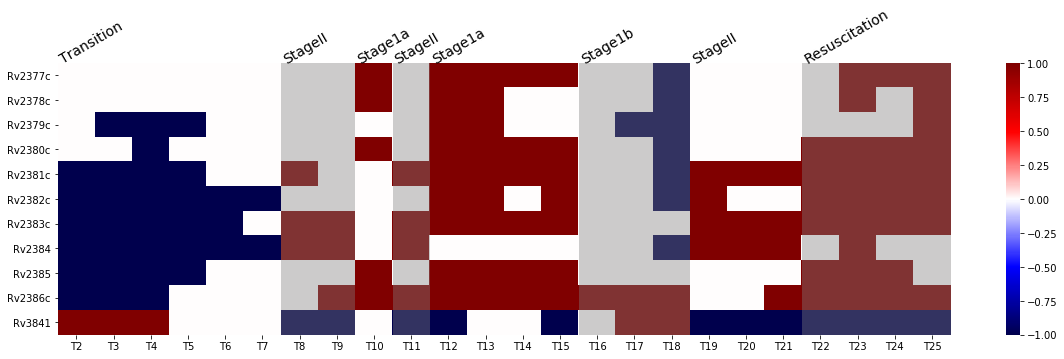

In [15]:
# Deeper look at training data
plotExpressionLevels(DATA.df_X, CLASSIFIER.features, ser_y=SER_Y, title="")

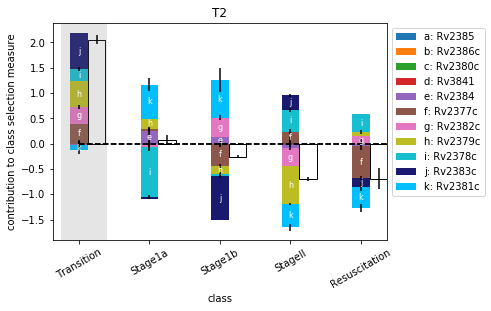

In [16]:
instances = ["T2"]
for instance in instances:
    CLASSIFIER.plotFeatureContributions(DF_X.loc[instance, :],
                    title=instance, true_class=SER_Y.loc[instance],
                    class_names=STAGE_NAMES)

In [17]:
len(CLASSIFIER.columns)

11

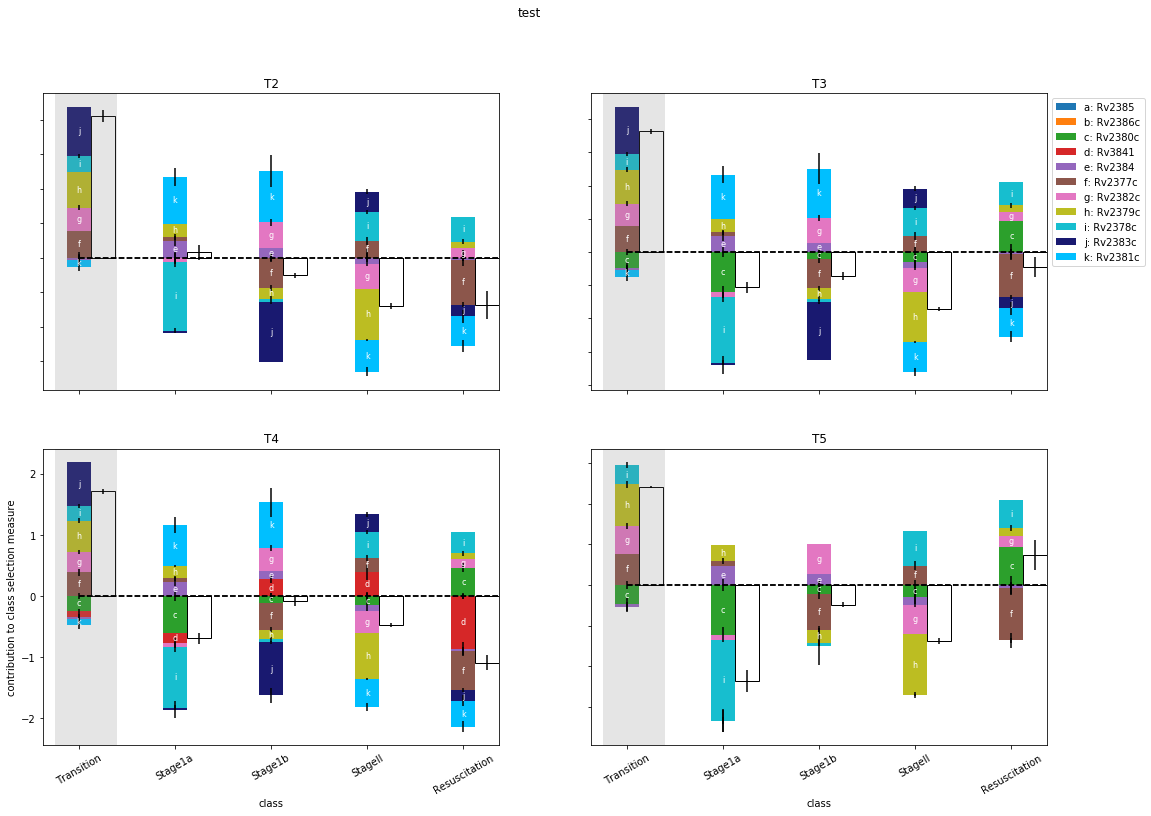

In [18]:
def evaluateClassifierOnInstances(clf, df_X=NEW_DATA.df_X, ser_y=None, class_names=None, is_plot=True, nrow=6, ncol=4, suptitle=""):
    _, axes = plt.subplots(nrow, ncol, figsize=(18,12))
    for irow in range(nrow):
        for icol in range(ncol):
            ax = axes[irow, icol]
            instance_num = irow*ncol + icol + 2
            instance = "T%d" % instance_num
            if instance not in df_X.index:
                break
            ser_X = df_X.loc[instance, :]
            if (icol + 1 == ncol) and (irow==0):
                is_legend = True
            else:
                is_legend = False
            if (irow + 1 == nrow):
                is_xlabel = True
                if icol == 0:
                    is_ylabel = True
                else:
                    is_ylabel = False
            else:
                is_ylabel = False
                is_xlabel = False
            clf.plotFeatureContributions(ser_X, ax=ax,
                    title=instance, true_class=ser_y.loc[instance], is_plot=False, is_legend=is_legend,
                                               class_names=class_names,
                                               is_xlabel=is_xlabel, is_ylabel=is_ylabel)
    plt.suptitle(suptitle)
    if not is_plot:
        plt.close()
    
# Tests
evaluateClassifierOnInstances(CLASSIFIER, ser_y=NEW_DATA.ser_y, class_names=STAGE_NAMES, is_plot=True, nrow=2, ncol=2, suptitle="test")

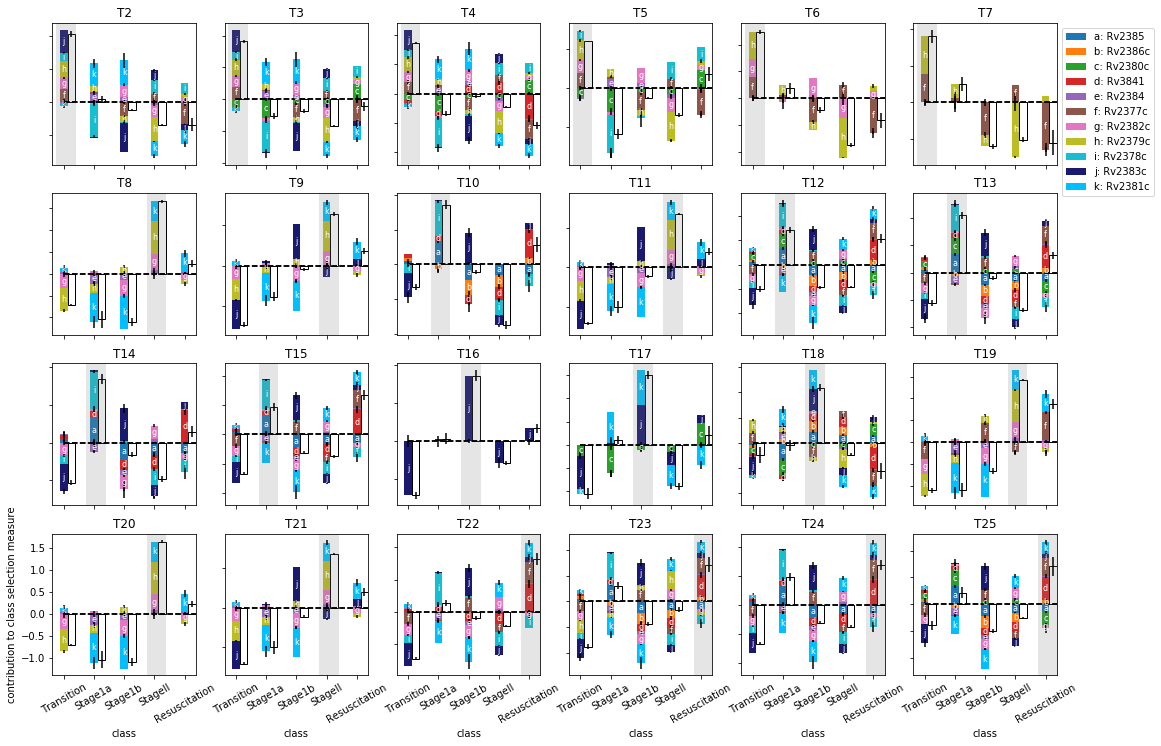

In [19]:
evaluateClassifierOnInstances(CLASSIFIER, ser_y=NEW_DATA.ser_y, class_names=STAGE_NAMES, nrow=4, ncol=6)

### Lab Samples

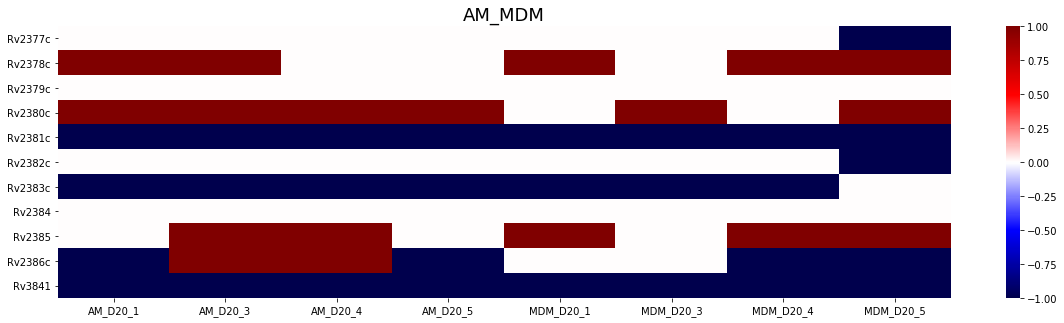

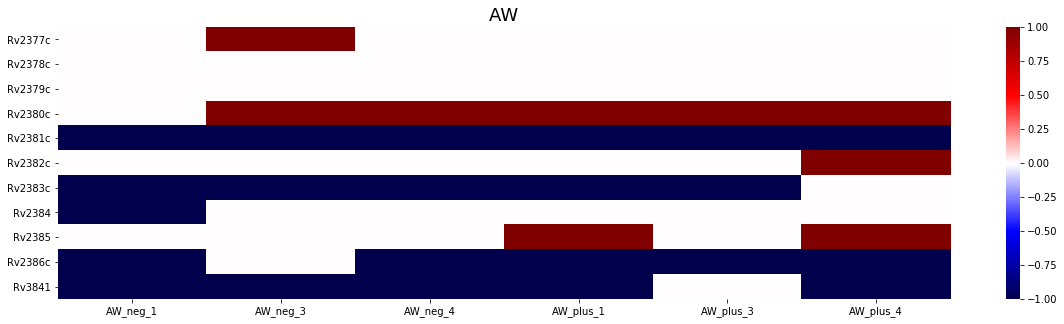

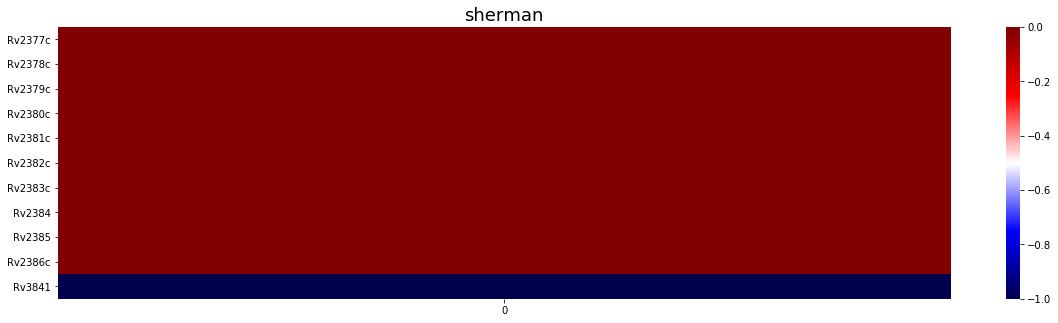

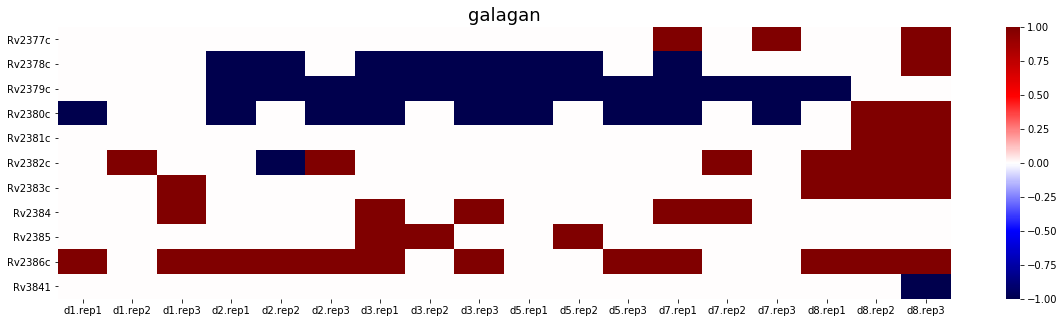

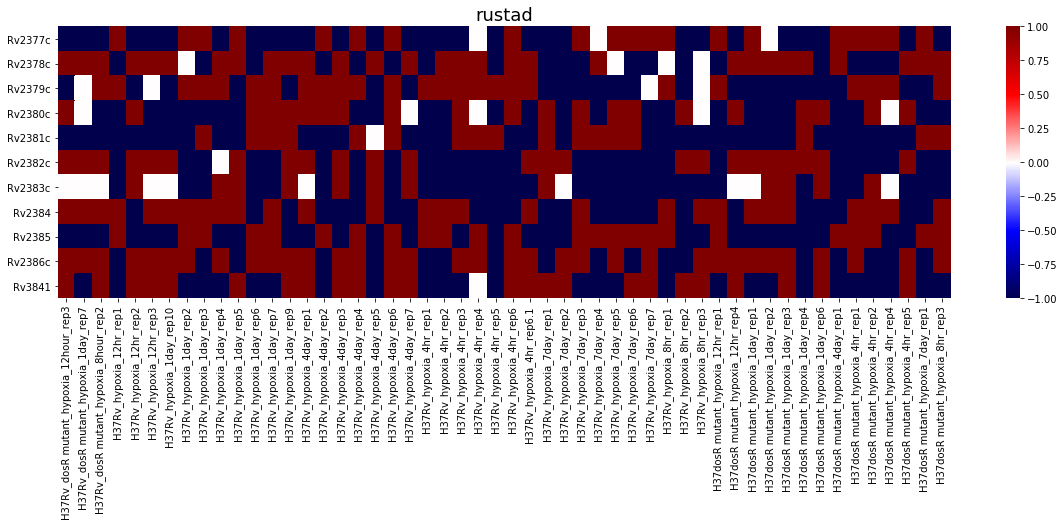

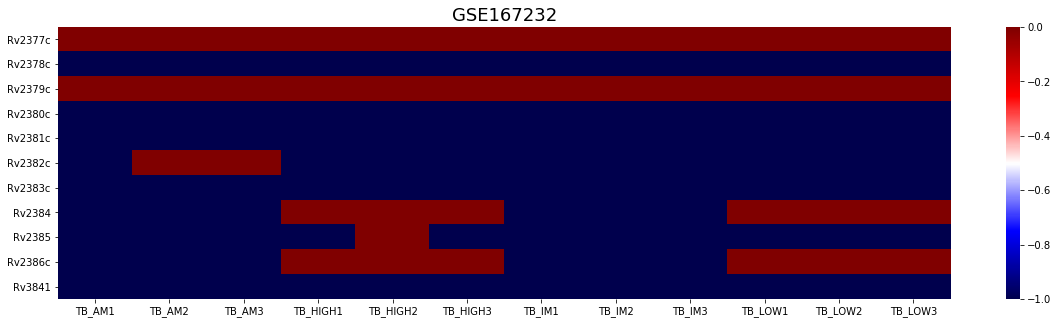

In [20]:
for sample in trinary_data.SAMPLES:
    if SAMPLE_BIOREACTOR_REF_DCT[sample] is not None:
        plotExpressionLevels(SAMPLE_BIOREACTOR_REF_DCT[sample], CLASSIFIER.features, title=sample)

# Classification Validations on Training Samples
Classify T2-T25 and see if result is same as original class. Use 5-fold cross validation, where there is a holdout for each class and the selection is random.


In [21]:
if False:
    accuracy_dct = {}
    ranks = [1, 2, 4, 8, 16, 32, 64, 128, 256]
    ranks = range(1,12)
    for rank in ranks:
        accuracy_dct[rank] = CLASSIFIER.crossValidate(
            NEW_DATA, num_iter=10, num_holdout=1, filter_high_rank=rank, size=100)
    plt.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()))
    plt.ylim([0, 1.1])
    _ = plt.xlabel("No genes in clasifier")
    _ = plt.ylabel("accuracy")

**TODO**: List the genes used for each coordinate.

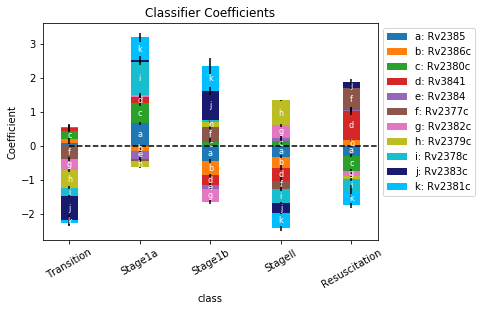

In [22]:
CLASSIFIER.plotSVMCoefficients(title="Classifier Coefficients", class_names=STAGE_NAMES)

The above chart displays the values of the SVM coefficients for each of the genes for the classifier used to identify each state. The vertical lines are error bars ($\pm$ 1 standard deviation) for the value of the coefficient over 100 classifiers constructed using 1 holdout per state.

The coefficients are used to identify the stage that best matches a gene expression vector. Given
an expression vector $\mathbf{x} = (x_1, \cdots, x_N)$, where $x_n \in [-1, 1 ]$ is the expression level of gene $x_n$ and
$c_{m,n}$ is the coefficient for the classifier for stage $m$ and gene $n$:
1. $d_m = \sum_n c_{m,n} x_n$
1. Choose stage $m^{\star}$ such that $m^{\star} = arg max_m \{ d_m \}$

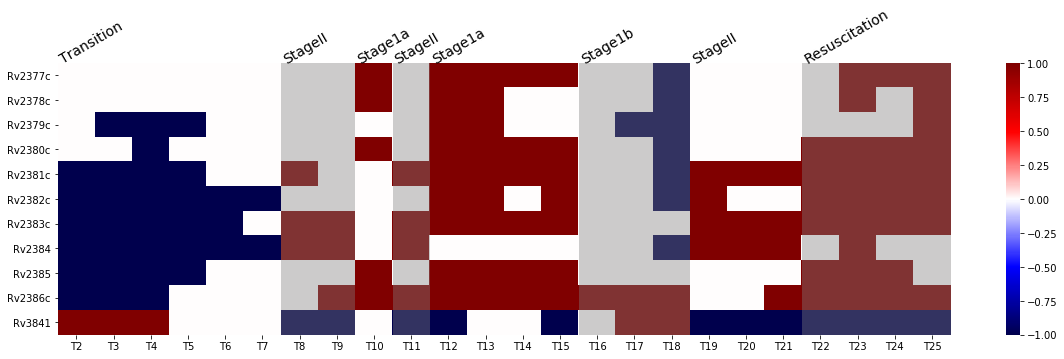

In [23]:
# Deeper look at training data
plotExpressionLevels(DATA.df_X, CLASSIFIER.features, ser_y=SER_Y, title="")

Several observations are of interest:
1. The coefficients for Transition are mostly negative, which means that this stage is about *under-expression*.
In particular, this stage is characterized by an under-expression of the genes Rv2383c, Rv2382c, Rv2386c, and Rv2385.
1. We see that Stage1a is characterized by large positive values of the coefficients for Rv2385, Rv3841, and Rv2384.
Although this makes sense for Rv2385, it is counter intuitive for
Rv2384 and Rv3841.
The rationale here is more complicated.
Rv2384 is not differentially expressed in Stage 1a; however, it is under-expressed in Transition.
So, a positive coefficient for Rv2384 for Stage 1a allows for differentiation from Transition.
A similar tactic seems to be in play for Rv3841 to distinguish Stage1a from Stage II and Resuscitation.
However, this is complicated by the fact that Transition over-expresses Rv3841.
The classifier compensates for this by having a large coefficient for Rv2384.

1. The other stages are characterized by a mixture of over- and under-expression.

In [24]:
CLASSIFIER.clfs[0].coef_

array([[-0.25985456, -0.73369192,  0.11081225, -0.10544725, -0.52138565,
         0.11081225, -0.39112365,  0.25809979,  0.11081225, -0.34389363,
         0.04916374],
       [ 1.02882114,  0.04390807,  0.15719239,  0.69463259, -0.2047497 ,
         0.68050334, -0.0570666 ,  0.62550751, -0.16316871,  0.07174899,
        -0.26823181],
       [ 0.12502891,  0.78034748, -0.54062986,  0.74685599,  0.10207206,
        -0.3662713 ,  0.5111874 ,  0.02597241, -0.3662713 , -0.32717204,
        -0.13821557],
       [-0.47353017, -0.32646009, -0.39354908, -0.47024553,  0.74368069,
        -0.29852739, -0.23173167,  0.09954989, -0.29852739,  0.343171  ,
         0.08668888],
       [-0.40528819,  0.18780179,  0.91746784, -0.41898151, -0.09031188,
        -0.29035795,  0.6563833 , -0.49972116,  0.19322473, -0.13400881,
         0.04680876]])

# Accuracy of Gene Groups

In [25]:
def plotAccuracy(genes, title="", selected_stages=None, size=100, is_plot=True, ax=None):
    """
    Plots the accuracy curve for a collection of genes
    
    Parameters
    ----------
    genes: list-str
    title: str
    selected_stages: list-str
        Create a binary classifier for just these tages
    size: int
    is_plot: bol
    """
    if ax is None:
        _, ax = plt.subplots(1)
    accuracy_dct = {}
    data = mkDataSubset(genes, selected_stages=selected_stages)
    ranks = range(1, len(genes) + 1)
    for rank in ranks:
        accuracy_dct[rank] = CLASSIFIER.crossValidate(
            data, num_iter=10, num_holdout=1, filter_high_rank=rank, size=size)
    ax.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()), marker="o")
    ax.set_ylim([0, 1.1])
    _ = ax.set_xlabel("No genes in clasifier")
    _ = ax.set_ylabel("accuracy")
    ax.set_title(title)
    if not is_plot:
        plt.close()
    return accuracy_dct
    
# Tests
genes = GENE_DCT["bacterioferritin 1"]
accuracy_dct = plotAccuracy(GENE_DCT["bacterioferritin 1"], title=", ".join(genes), selected_stages="StageII", size=5, is_plot=False)
assert(np.isclose(list(accuracy_dct.values())[0], 0.5))

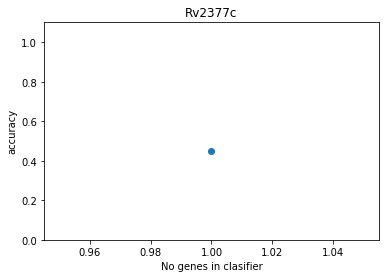

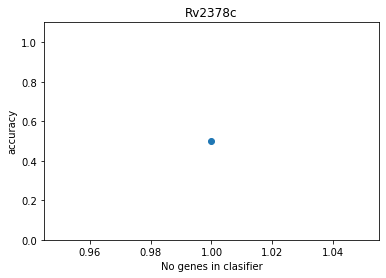

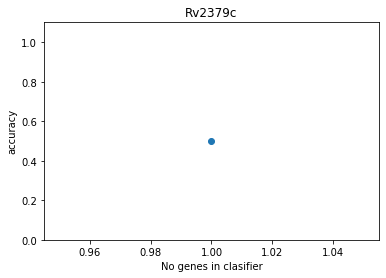

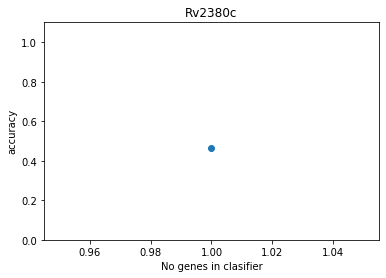

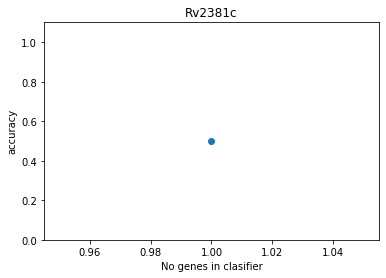

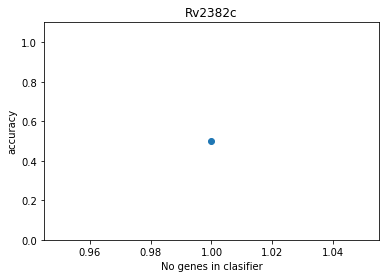

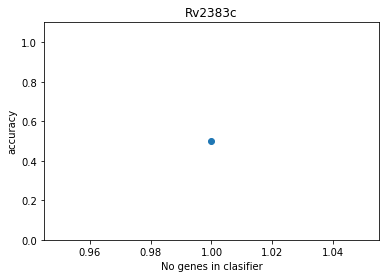

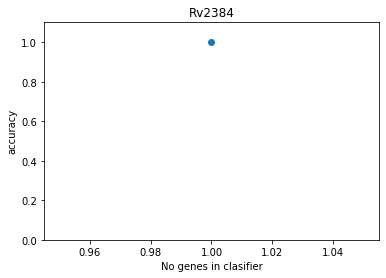

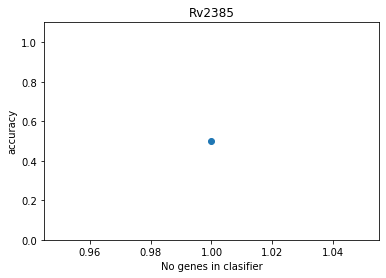

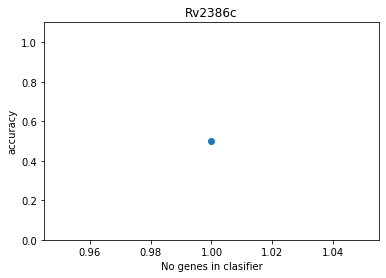

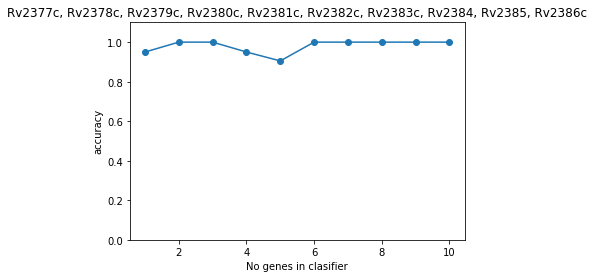

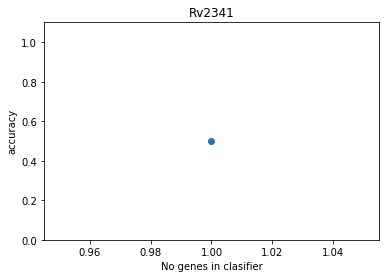

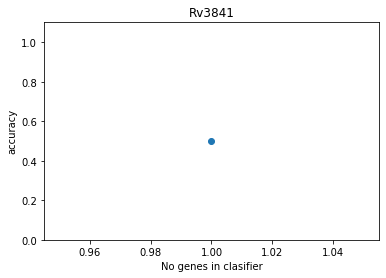

In [26]:
gene_dct = {g: [g] for g in GENE_DCT["mycobactin"]}
gene_dct.update(GENE_DCT)
for name, genes in gene_dct.items():
    _, ax = plt.subplots(1)
    _ = accuracy_dct = plotAccuracy(genes, title=", ".join(genes), selected_stages=["StageII"], ax=ax, size=100)

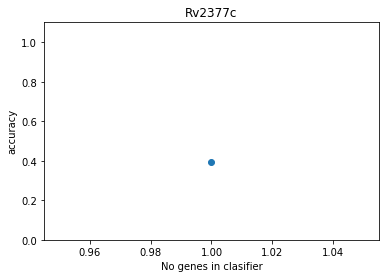

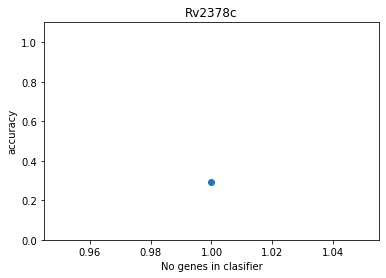

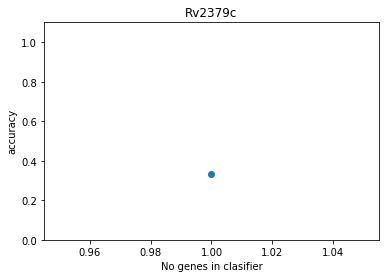

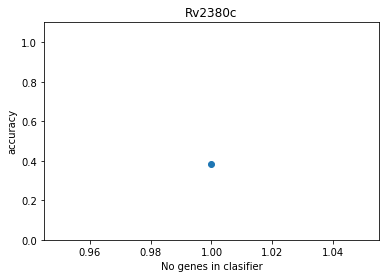

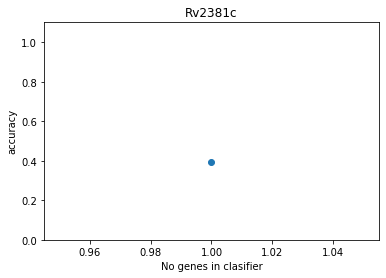

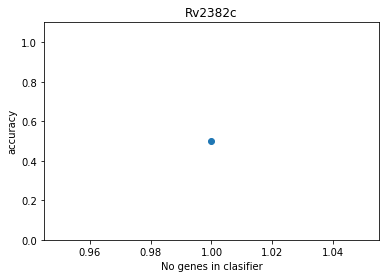

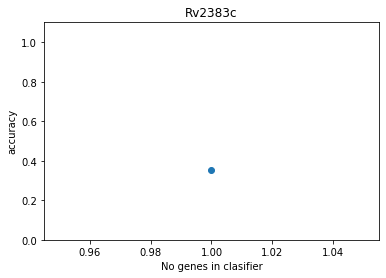

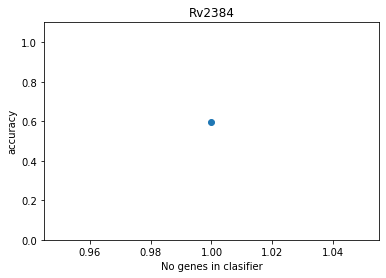

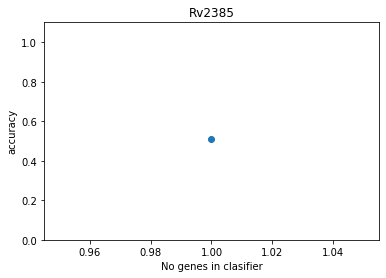

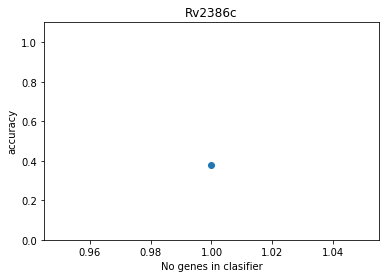

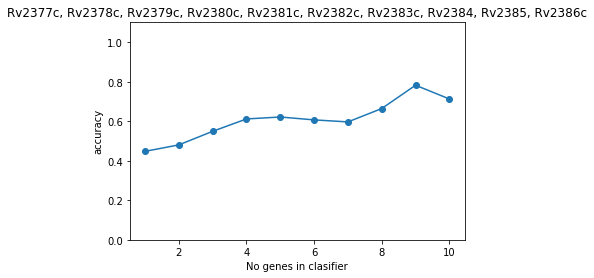

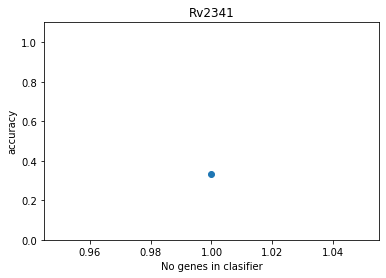

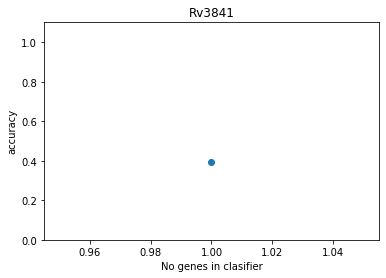

In [27]:
gene_dct = {g: [g] for g in GENE_DCT["mycobactin"]}
gene_dct.update(GENE_DCT)
for name, genes in gene_dct.items():
    _, ax = plt.subplots(1)
    _ = accuracy_dct = plotAccuracy(genes, title=", ".join(genes), ax=ax, size=100)

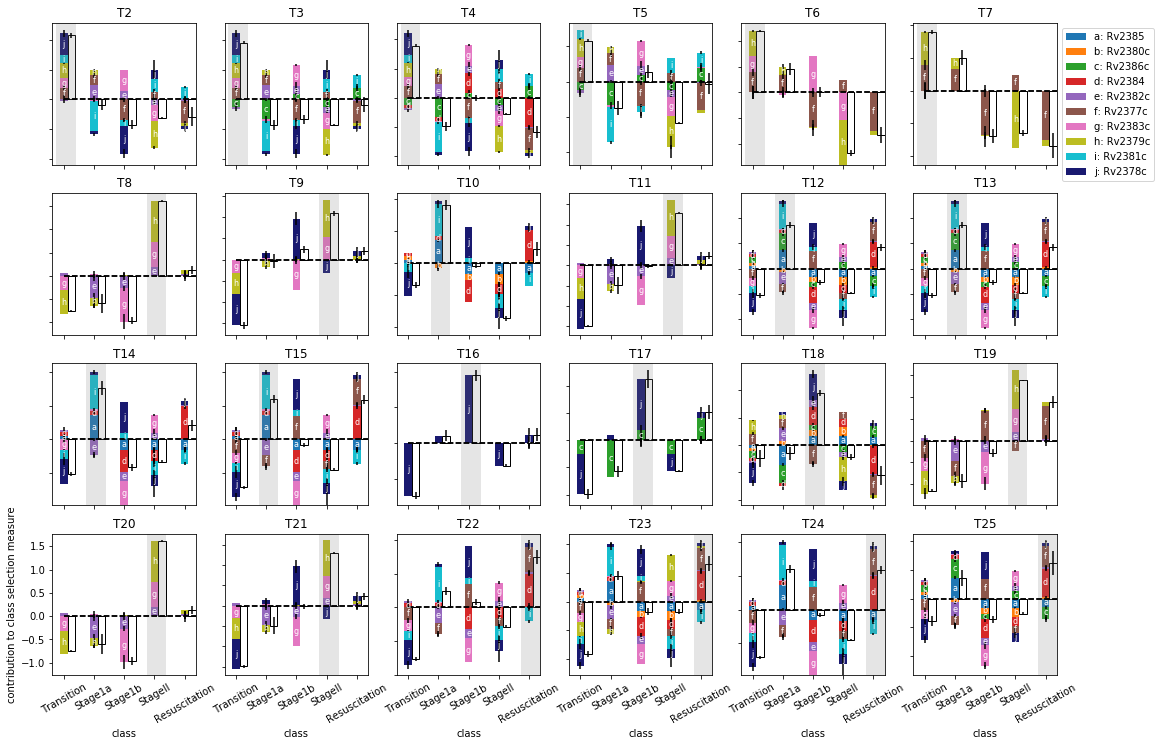

In [28]:
# Details for the 10 genes
df_X = DF_X[GENE_DCT["mycobactin"]]
num_genes = range(1, len(df_X.columns) + 1)
num_genes = [10]
for num_gene in num_genes:
    clf = classifier_ensemble.ClassifierEnsemble(
            classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=num_gene, size=100)
    clf.fit(df_X, SER_Y)
    evaluateClassifierOnInstances(clf, df_X=df_X, ser_y=NEW_DATA.ser_y, class_names=STAGE_NAMES, nrow=4, ncol=6, is_plot=True)

## Evaluation for good performing genes

In [29]:
ser_X = pd.Series([1])
ser_X.index = ["Rv2384"]
df_X = pd.DataFrame(ser_X).T
clf.predict(pd.DataFrame(df_X))

***Warning: missing columns in prediction vector. 
 ['Rv2386c', 'Rv2381c', 'Rv2385', 'Rv2378c', 'Rv2382c', 'Rv2377c', 'Rv2380c', 'Rv2379c', 'Rv2383c']


,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0


In [30]:
genes = ["Rv2384"]
data = mkDataSubset(genes, selected_stages=["StageII"])
clf = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=20, size=100)
clf.fit(data.df_X, data.ser_y)
clf.plotSVMCoefficients(title="Classifier Coefficients", class_names=["Not StageII", "StageII"])

KeyError: 1

# Classification of Samples

In [ ]:
CLASSIFIER.features

In [ ]:
CLASSIFIER.predict(SAMPLE_BIOREACTOR_REF_DCT["AM_MDM"])

In [ ]:
CLASSIFIER.predict(SAMPLE_NOTBIOREACTOR_REF_DCT["AM_MDM"])

In [ ]:
# Combine states - 0 + 4 == neg; 1,2,3 = pos
# Use uncurated baseline for AW, others?

In [31]:
def reportSamplePredictions(sample_dct):
    for sample, df_X in sample_dct.items():
        print("\n\n%s" % sample)
        df = CLASSIFIER.predict(df_X)
        df.columns = STAGE_NAMES[np.array(df.columns)]
        ordered_columns = ["Transition", "Stage1a", "Stage1b", "StageII", "Resuscitation"]
        df = df[ordered_columns]
        print(df)

In [ ]:
reportSamplePredictions(SAMPLE_NOTBIOREACTOR_REF_DCT)

In [50]:
reportSamplePredictions(SAMPLE_BIOREACTOR_REF_DCT)



AM_MDM
           Transition  Stage1a  Stage1b  StageII  Resuscitation
AM_D20_1         1.00     0.00     0.00      0.0           0.00
AM_D20_3         0.00     0.11     0.00      0.0           0.89
AM_D20_4         0.00     0.09     0.07      0.0           0.84
AM_D20_5         1.00     0.00     0.00      0.0           0.00
MDM_D20_1        0.86     0.11     0.00      0.0           0.03
MDM_D20_3        0.82     0.00     0.00      0.0           0.18
MDM_D20_4        1.00     0.00     0.00      0.0           0.00
MDM_D20_5        1.00     0.00     0.00      0.0           0.00


AW
           Transition  Stage1a  Stage1b  StageII  Resuscitation
AW_neg_1         1.00     0.00      0.0      0.0           0.00
AW_neg_3         1.00     0.00      0.0      0.0           0.00
AW_neg_4         1.00     0.00      0.0      0.0           0.00
AW_plus_1        1.00     0.00      0.0      0.0           0.00
AW_plus_3        1.00     0.00      0.0      0.0           0.00
AW_plus_4        0.08     

# Detailed Analyses

## GSE167232

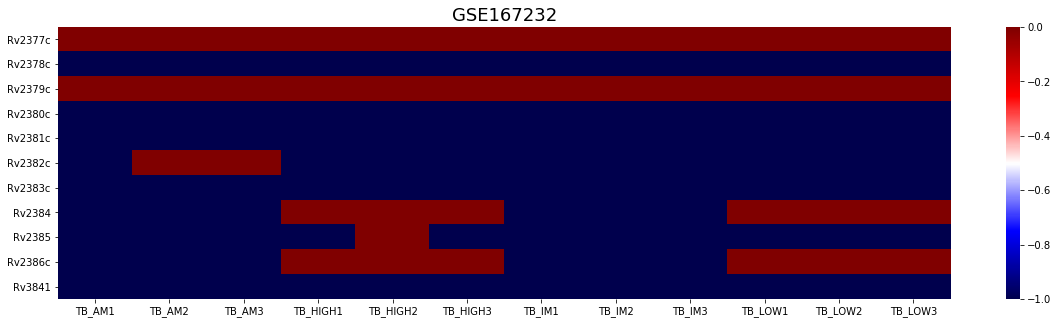

In [69]:
plotExpressionLevels(SAMPLE_BIOREACTOR_REF_DCT["GSE167232"], CLASSIFIER.features, title="GSE167232")

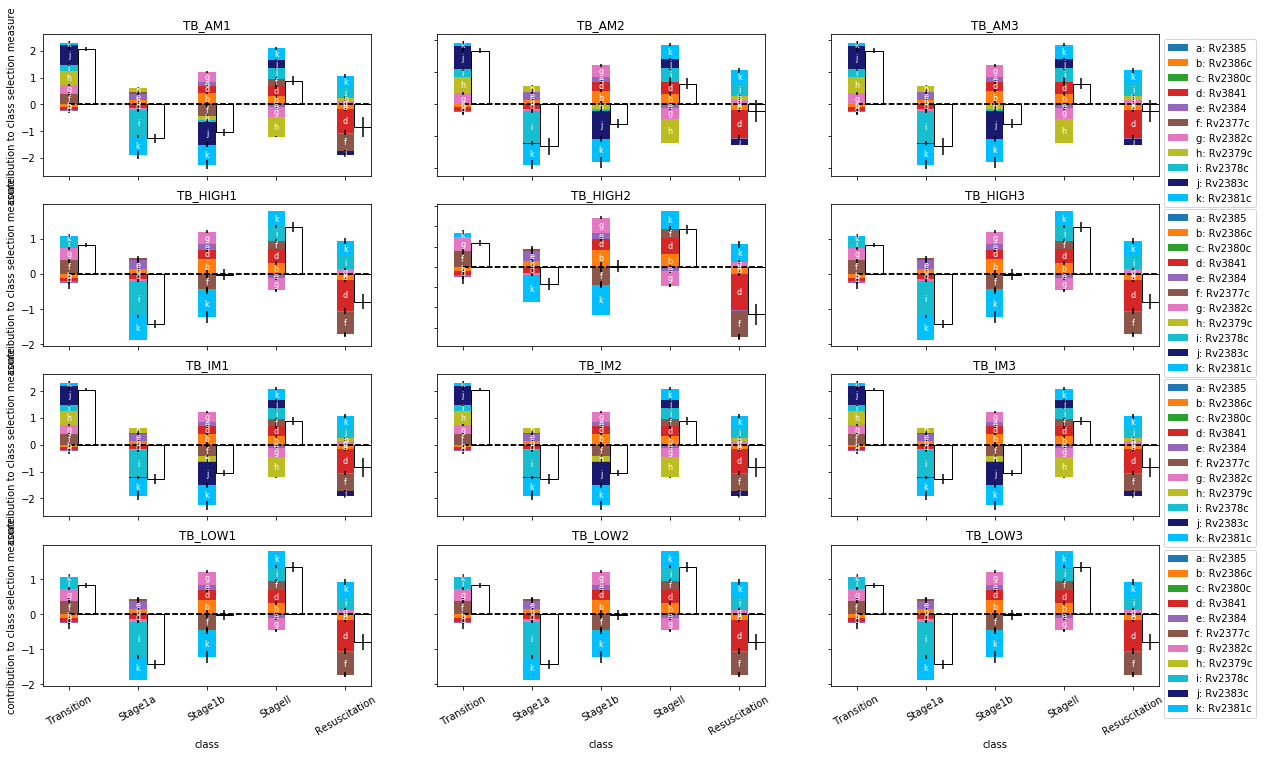

In [72]:
#CLASSIFIER.plotFeatureContributions(df_X.loc["TB_AM1",:], class_names=STAGE_NAMES)
df_predict = CLASSIFIER.predict(SAMPLE_BIOREACTOR_REF_DCT["GSE167232"])
indexArr = np.reshape(list(df_predict.index), (4,3))
num_row = 4
num_col =3
_, axes = plt.subplots(num_row, num_col, figsize=(20, 12))
for irow in range(4):
    for icol in range(3):
        if icol == 0:
            is_ylabel = True
        else:
            is_ylabel = False
        if icol == num_col - 1:
            is_legend = True
        else:
            is_legend = False
        if irow == num_row - 1:
            is_xlabel = True
        else:
            is_xlabel = False
        instance = indexArr[irow, icol]
        ser_X = SAMPLE_BIOREACTOR_REF_DCT["GSE167232"].loc[instance, :]
        CLASSIFIER.plotFeatureContributions(ser_X, class_names=STAGE_NAMES, title=instance, ax=axes[irow,icol], is_plot=False,
                                           is_xlabel=is_xlabel, is_ylabel=is_ylabel, is_legend=is_legend)
plt.show()

In [61]:
df_X

Rv0001    -1
Rv0005    -1
Rv0006    -1
Rv0009    -1
Rv0010c   -1
          ..
Rv3919c   -1
Rv3920c    0
Rv3922c   -1
Rv3923c   -1
Rv3924c   -1
Name: TB_AM1, Length: 2319, dtype: int64

## Rustad

In [ ]:
# Rustad analysis
df_X = SAMPLE_BIOREACTOR_REF_DCT["rustad"]
df_pred = CLASSIFIER.predict(df_X)
instances = [i for i in df_pred.index if "H37Rv_hypoxia" in i]
df_pred = df_pred.loc[instances, :]
times = []
replications = []
for instance in instances:
    if "hr" in instance:
        pos = instance.index("hr_")
    else:
        pos = instance.index("ay_")
    last_pos = pos + 2
    times.append(instance[0:last_pos])
    if "10" in instance:
        replications.append(instance[-2:])
    else:
        replications.append(instance[-1])
timeArr = np.array(times)
replicationArr = np.array(replications)
indexArr = list(df_pred.index)
indexArr = np.array(indexArr)
#
state_dct = {}
for time in set(times):
    idxs = [p for p, i in enumerate(indexArr) if time in i]
    replications_sub = replicationArr[idxs]
    times_sub = timeArr[idxs]
    state_dct[time] = []
    for instance in indexArr[idxs]:
        max_val = np.max(df_pred.loc[instance, :].values)
        state = [s for s in df_pred.columns if df_pred.loc[instance, s] == max_val][0]
        state_dct[time].append(STAGE_NAMES[state])

In [ ]:
time_keys = np.array(["H37Rv_hypoxia_4hr", "H37Rv_hypoxia_8hr", "H37Rv_hypoxia_12hr",
                      "H37Rv_hypoxia_1day", "H37Rv_hypoxia_4day", "H37Rv_hypoxia_7day"])
truncated_time_keys = np.array(["4hr", "8hr", "12hr",
                      "1day", "4day", "7day"])
time_idxs = np.array([list(state_dct.keys()).index(k) for k in time_keys])
repl_dct = {}
for repl in [0, 1, 2]:
    repl_dct[repl] = [state_dct[t][repl] for t in time_keys[time_idxs]]

In [ ]:
_, ax = plt.subplots(1)
repl_dct[-1] = ["Transition", "Stage1a", "Stage1b", "StageII", "Resuscitation"]
repl_dct[-1] = repl_dct[0]
repl_dct[-1][0] = "Transition"
repl_dct[-1][1] = "Stage1a"
repl_dct[-1][2] = "Stage1b"
repl_dct[-1][3] = "StageII"
repl_dct[-1][4] = "Resuscitation"
colors = ["red", "blue", "green"]
for repl in range(-1, 3):
    if repl == -1:
        color = "black"
    else:
        color = colors[repl]
    ax.plot(truncated_time_keys, repl_dct[repl], color=color)
plt.legend([0, 1, 2], loc="upper left")
plt.xlabel("time")
plt.ylabel("Stage")

## AM, MDM

In [ ]:
SAMPLE_BIOREACTOR_REF_DCT["AM_MDM"]

In [ ]:
df = SAMPLE_BIOREACTOR_REF_DCT["AM_MDM"] - SAMPLE_NOTBIOREACTOR_REF_DCT["AM_MDM"]
df = df.T.dropna(axis=1, how='all').T
_ = plt.hist(df.values.flatten(), bins=20)

## Galagan

In [ ]:
**TODO**: Plot progression of replications over time